In [92]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from u_net import UNet
from deep_labv3_plus import get_deeplabv3plus_model

import torchvision.utils as vutils
import torchvision.transforms.functional as TF
import os


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

In [93]:
# Config
USE_DEEPLAB = False
IMAGE_SIZE = (120, 70)
NUM_CLASSES = 10
BATCH_SIZE = 4
EPOCHS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mappatura esplicita dei valori della maschera (esempio)
LABEL_VALUES = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]  # 10 classi

# def map_mask(mask_array):
#     mapped = np.zeros_like(mask_array)
#     for i, val in enumerate(LABEL_VALUES):
#         mapped[mask_array == val] = i
#     return mapped

def map_mask(mask):
    mapped_mask = np.zeros_like(mask)
    
    mapping = {
        0: 0,
        23: 1,
        76: 2,
        150: 3,
        165: 4,
        195: 5,
        210: 6,
        230: 7,
        240: 8,
        255: 9
    }
    
    for original_value, class_index in mapping.items():
        mapped_mask[mask == original_value] = class_index

    return mapped_mask





# Ottieni tutte le coppie immagine-maschera
all_images = sorted([os.path.join("./output/images", f) for f in os.listdir("./output/images")])
all_masks = sorted([os.path.join("./output/masks_color", f) for f in os.listdir("./output/masks_color")])

# Dividi in train e val
train_imgs, val_imgs, train_masks, val_masks = train_test_split(all_images, all_masks, test_size=0.2, random_state=42)




In [94]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform  # 🔧 aggiunto

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carica immagine e maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Maschera in scala di grigi

        # Debug e salvataggio maschere mappate per i primi 3 esempi
        if idx < 3:
            # mask_np = np.array(mask)
            # print("Mask before mapping:", np.unique(mask_np))

            # mask_np = map_mask(mask_np)
            # print("Mask after mapping:", np.unique(mask_np))


            print("Classi uniche prima della mappatura:", np.unique(np.array(mask)))
            print("Valori unici nella maschera originale:", np.unique(mask))

            mask_np = map_mask(np.array(mask))
            print("Classi uniche dopo la mappatura:", np.unique(mask_np))


            Image.fromarray(mask_np.astype(np.uint8)).save(f"check_mask_raw_{idx}.png")
            Image.fromarray((mask_np * 25).astype(np.uint8)).save(f"check_mask_mapped_{idx}.png")

            mask = Image.fromarray(mask_np.astype(np.uint8))

        # Applica trasformazioni
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = transforms.PILToTensor()(mask).squeeze(0).long()  # shape [H, W], dtype: long

        return image, mask




In [95]:
train_dataset = SegmentationDataset(train_imgs, train_masks)
val_dataset = SegmentationDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) #true
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)






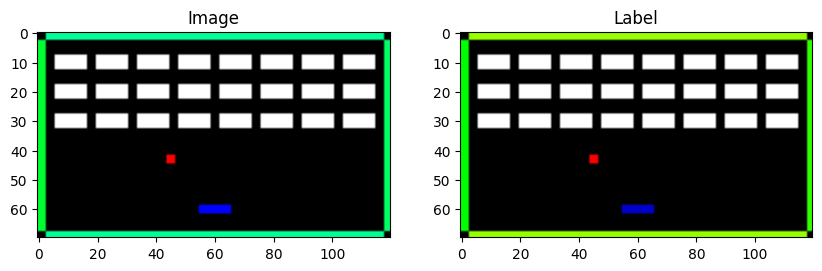

In [96]:
# Load and visualize an image and its corresponding label
image_path = "./output/images/frame_0000.png"
label_path = "./output/masks_color/frame_0000.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()

In [97]:
# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

In [98]:
def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# def show_mask(mask_tensor, num_classes=7):
#     """ Display the mask using matplotlib. """
#     # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
#     mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
#     label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

#     plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
#     plt.colorbar()  # Optionally add a color bar
#     plt.axis('off')  # Hide axes
#     plt.show()

def show_mask(mask_tensor, num_classes=10):
    """Visualizza la maschera di segmentazione semantica."""
    mask_np = mask_tensor.detach().cpu().numpy()

    # Caso 1: one-hot (C, H, W)
    if mask_np.ndim == 3:
        label_mask = np.argmax(mask_np, axis=0)  # Shape: (H, W)
    # Caso 2: già label map (H, W)
    elif mask_np.ndim == 2:
        label_mask = mask_np
    else:
        raise ValueError(f"Forma maschera non valida: {mask_np.shape}")

    # Visualizzazione
    plt.imshow(label_mask, cmap='tab20', vmin=0, vmax=num_classes - 1)
    plt.colorbar()
    plt.axis('off')
    plt.title("Mask")
    plt.show()

Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]


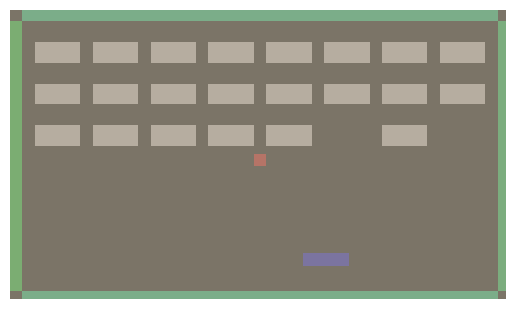

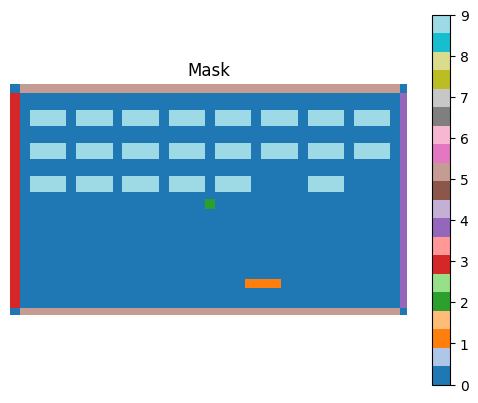

Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]


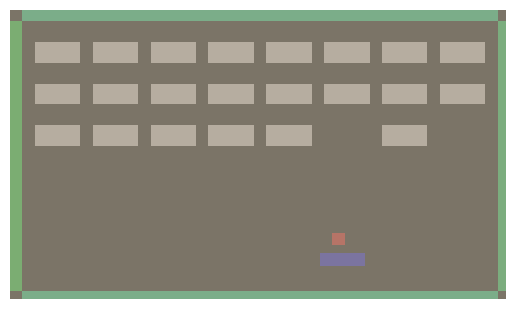

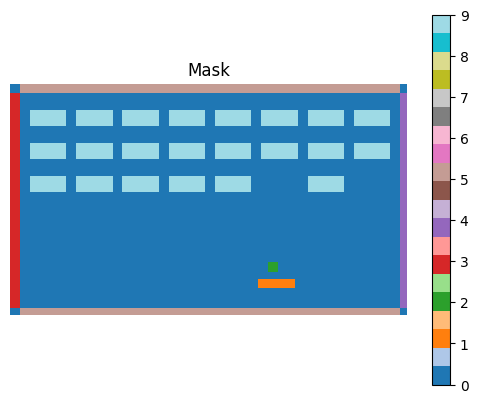

Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]


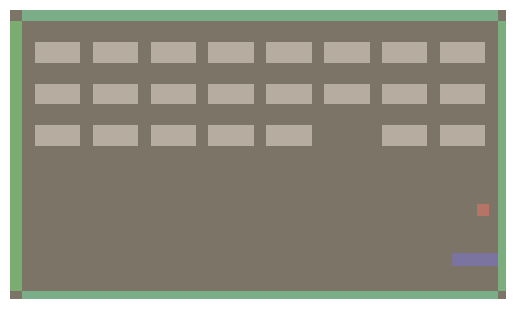

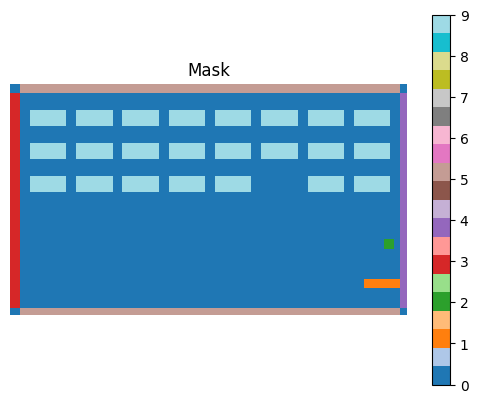

In [99]:
for i in range(3):
    image, mask = train_dataset[i]
    show_image(image)
    show_mask(mask)

Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]
Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]
Classi uniche prima della mappatura: [  0  23  76 150 165 195 255]
Valori unici nella maschera originale: [  0  23  76 150 165 195 255]
Classi uniche dopo la mappatura: [0 1 2 3 4 5 9]


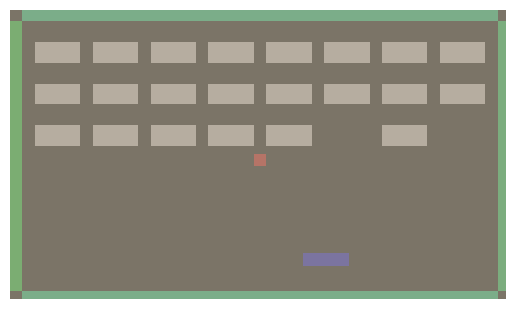

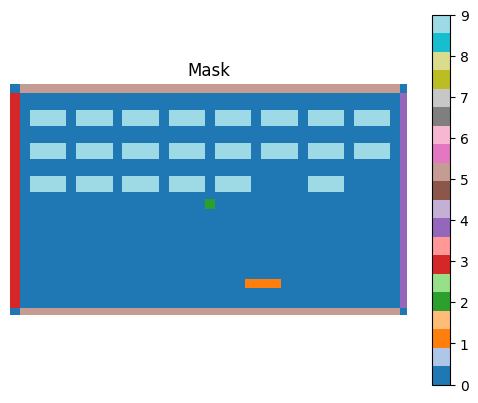

In [100]:
# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break